Đã xử lý: ha-long-bay-in-vietnam.jpg


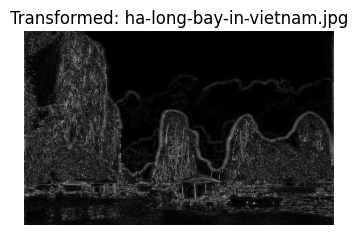

Đã xử lý: pagoda.jpg


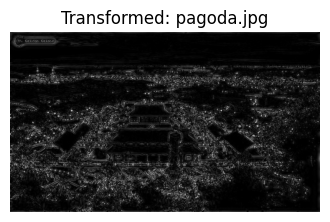

Đã xử lý: quang_ninh.jpg


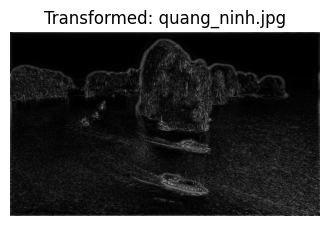

In [5]:
import cv2
import numpy as np
import os
import matplotlib.pyplot as plt

def show_image(image, title="Ảnh"):
    plt.figure(figsize=(4, 4))
    cmap = 'gray' if len(image.shape) == 2 else None
    plt.imshow(image, cmap=cmap)
    plt.title(title)
    plt.axis("off")
    plt.show()

# Hàm thực hiện biến đổi Fast Fourier Transform (FFT)
def fast_fourier_transform(image):
    dft = cv2.dft(np.float32(image), flags=cv2.DFT_COMPLEX_OUTPUT)
    dft_shift = np.fft.fftshift(dft)
    magnitude_spectrum = cv2.magnitude(dft_shift[:,:,0], dft_shift[:,:,1])
    
    # Chuẩn hóa giá trị để hiển thị ảnh rõ hơn
    magnitude_spectrum = np.log(1 + magnitude_spectrum)
    magnitude_spectrum = cv2.normalize(magnitude_spectrum, None, 0, 255, cv2.NORM_MINMAX)
    magnitude_spectrum = magnitude_spectrum.astype(np.uint8)

    return magnitude_spectrum

# Hàm tạo bộ lọc Butterworth Lowpass
def butterworth_lowpass_filter(shape, d0=30, n=2):
    rows, cols = shape
    center = (rows // 2, cols // 2)
    H = np.zeros((rows, cols), dtype=np.float32)
    for i in range(rows):
        for j in range(cols):
            D = np.sqrt((i - center[0]) ** 2 + (j - center[1]) ** 2)
            H[i, j] = 1 / (1 + (D / d0) ** (2 * n))
    return H

# Hàm tạo bộ lọc Butterworth Highpass
def butterworth_highpass_filter(shape, d0=30, n=2):
    return 1 - butterworth_lowpass_filter(shape, d0, n)

# Hàm áp dụng bộ lọc Butterworth
def apply_butterworth_filter(image, filter_type="lowpass"):
    dft = cv2.dft(np.float32(image), flags=cv2.DFT_COMPLEX_OUTPUT)
    dft_shift = np.fft.fftshift(dft)
    
    filter_func = butterworth_lowpass_filter if filter_type == "lowpass" else butterworth_highpass_filter
    H = filter_func(image.shape)
    
    dft_shift[:,:,0] *= H
    dft_shift[:,:,1] *= H
    
    dft_ishift = np.fft.ifftshift(dft_shift)
    img_back = cv2.idft(dft_ishift)
    img_back = cv2.magnitude(img_back[:,:,0], img_back[:,:,1])
    
    return cv2.normalize(img_back, None, 0, 255, cv2.NORM_MINMAX).astype(np.uint8)

# Đọc ảnh từ thư mục exercise và xử lý
def process_images(transformation_func=None, output_folder="", filter_type=None):
    input_folder = "exercise"
    os.makedirs(output_folder, exist_ok=True)
    
    for filename in os.listdir(input_folder):
        if filename.lower().endswith((".png", ".jpg", ".jpeg")):
            image_path = os.path.join(input_folder, filename)
            image = cv2.imread(image_path, cv2.IMREAD_GRAYSCALE)

            if transformation_func:
                transformed_image = transformation_func(image)
            elif filter_type in ["lowpass", "highpass"]:
                transformed_image = apply_butterworth_filter(image, filter_type)
            else:
                print("Không có phép biến đổi hợp lệ.")
                continue

            output_path = os.path.join(output_folder, filename)
            cv2.imwrite(output_path, transformed_image)
            print(f"Đã xử lý: {filename}")
            show_image(transformed_image, f"Transformed: {filename}")

option = input("Chọn phương pháp (F/L/H): ").strip().upper()

if option == "F":
    process_images(fast_fourier_transform, "output_fft")
elif option == "L":
    process_images(None, "output_lowpass", "lowpass")
elif option == "H":
    process_images(None, "output_highpass", "highpass")
else:
    print("Lựa chọn không hợp lệ.")